<div class="alert alert-block alert-warning">

<h1>Mental Health</h1>
    
<a href="https://www.kaggle.com/datasets/reihanenamdari/mental-health-corpus">Kaggle Link</a>

    
<h2>About Dataset</h2>
<blockquote>The Mental Health Corpus is a collection of texts related to people with anxiety, depression, and other mental health issues. The corpus consists of two columns: one containing the comments, and the other containing labels indicating whether the comments are considered poisonous or not. The corpus can be used for a variety of purposes, such as sentiment analysis, toxic language detection, and mental health language analysis. The data in the corpus may be useful for researchers, mental health professionals, and others interested in understanding the language and sentiment surrounding mental health issues.
</blockquote>
</div>

<hr>

<div class="alert alert-block alert-info">
    <h2>Columns</h2>
    <p><strong>text:</strong> The comments.</p>
    <p><strong>label:</strong> 1 means considered as a comment which is poisonous with mental health issues, and 0 means not considered.</p>
</div>

## Importing Libraries and Dataset

In [1]:
# !pip install collections
# !pip install wordcloud
# !pip install contractions
# !pip install autocorrect
# !pip install unidecode
# !pip install rake_nltk
# !pip install yake
# !pip install gensim
# !pip install yellowbrick
# !pip install imblearn

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
# to get counts and most common elements
from collections import Counter

# to get wordcloud
from wordcloud import WordCloud

# to fetch ngrams
from nltk.util import ngrams

# to expand the text (don't to do not)
import contractions

# to auto correct the words
from autocorrect import Speller

# for handling accented characters (Á to A)
from unidecode import unidecode

# to get list of punctuations
from string import punctuation

# nltk libraries 
from nltk.tokenize import word_tokenize # to make tokens (sentence/words)
from nltk.corpus import stopwords # to get list of stopwords
from nltk.stem import WordNetLemmatizer # to find root words

# for extracting the keywords
import yake
from rake_nltk import Rake

# for making vectors of the documents
from gensim.models import Word2Vec, keyedvectors

# to see how the clusters are generated
from yellowbrick.cluster import SilhouetteVisualizer

# scikit_learn libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

# to balance the data
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import RandomizedSearchCV

In [4]:
df = pd.read_csv('mental_health.csv')
df.head()

,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1


## EDA

In [5]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [6]:
df.label.unique()

array([0, 1], dtype=int64)

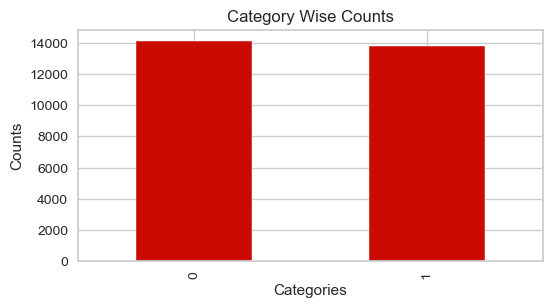

In [7]:
_ = df['label'].value_counts()
plt.figure(figsize = (6,3))
_.plot(kind = "bar",color = "r")
plt.ylabel("Counts")
plt.xlabel("Categories")
plt.title("Category Wise Counts")
plt.show()

In [8]:
# defining function to get ngrams
def get_ngrams(data, n_range):
    tokens = data.split()
    ngrms  = ngrams(tokens, n_range ) # provide zip file
    ngrms_lst = []
    for i in ngrms: #unzipping the file
        ngrms_lst.append(" ".join(i))
    return ngrms_lst

In [9]:
# getting unigrams
unigrams = df['text'].apply(lambda x: get_ngrams(x,1))
unigrams.head(10)

0    [dear, american, teens, question, dutch, perso...
1    [nothing, look, forward, lifei, dont, many, re...
2    [music, recommendations, im, looking, expand, ...
3    [im, done, trying, feel, betterthe, reason, im...
4    [worried, year, old, girl, subject, domestic, ...
5    [hey, rredflag, sure, right, place, post, this...
6    [feel, like, someone, needs, hear, tonight, fe...
7    [deserve, liveif, died, right, noone, would, c...
8    [feels, good, ive, set, dateim, killing, frida...
9    [live, guiltok, made, stupid, random, choice, ...
Name: text, dtype: object

In [11]:
# checking most repeated words from all the texts
lst = []
for i in unigrams:
    lst.extend(i)
Counter(lst).most_common(10)

[('im', 34720),
 ('like', 22300),
 ('want', 17299),
 ('know', 15475),
 ('feel', 14508),
 ('life', 14386),
 ('get', 13094),
 ('one', 12405),
 ('me', 12313),
 ('even', 11497)]

In [12]:
# cheking most repeted 10 trigrams
trigram = df['text'].apply(lambda x: get_ngrams(x,3))
lst1 = []
for i in trigram:
    lst1.extend(i)
Counter(lst1).most_common(10)

[('filler filler filler', 2653),
 ('feel like im', 702),
 ('gtpoplt gtpoplt gtpoplt', 326),
 ('water nowdrink water', 323),
 ('nowdrink water nowdrink', 287),
 ('quick brown jumps', 284),
 ('brown jumps lazy', 284),
 ('jumps lazy quick', 283),
 ('lazy quick brown', 283),
 ('want kill myself', 219)]

In [13]:
def get_wordcloud(data,column):
    df_ = data[column].str.cat(sep = " ")
    text = " ".join([i for i in df_.split()])
    wcloud = WordCloud(width = 700, height = 500, background_color = "lightgreen").generate(text)
    plt.figure(figsize = (10,6))
    plt.imshow(wcloud)
    plt.axis("off")
    plt.title("Word Cloud")
    plt.show()

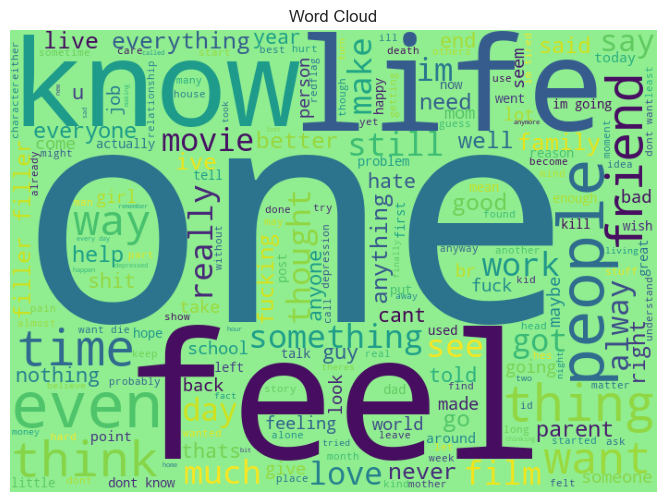

In [14]:
#plotting word cloud
get_wordcloud(df,'text')

## Preprocessing

In [15]:
# Cleaning the data
def remove_spaces(data):
    clean_text = data.replace("\\n"," ").replace("\t"," ").replace("\\"," ")
    return clean_text

# defining the function for expanding text (can't to can not)
def expand_text(data):
    ex_text = contractions.fix(data)
    return ex_text

# defining the function for handling accented characters (Á to A)
def handling_accented(data):
    fix_text = unidecode(data)
    return fix_text

# defining the function for removing stopwords
stopword = stopwords.words("english") # gives a list of stopwords

# removing neccessary stop words from list
stopword.remove("no") 
stopword.remove("not")
stopword.remove("nor")

def clean_text(data):
    token = word_tokenize(data)
    clean_text = [i.lower() for i in token if (i not in punctuation) 
                  and (i.lower() not in stopword) and (i.isalpha()) and (len(i) > 2)]
    return clean_text

# defining the function for auto correction 
def auto_correct(data):
    spell = Speller(lang = "en")
    text = spell(data)
    return text

# defining the function for getting root words
def lemmatization(data):
    lem = WordNetLemmatizer()
    lst1 = []
    for i in data:
        lem_words = lem.lemmatize(i)
        lst1.append(lem_words)
    return " ".join(lst1)

In [16]:
df["clean_text"] = df["text"].apply(remove_spaces)
df["clean_text"] = df["clean_text"].apply(expand_text)
df["clean_text"] = df["clean_text"].apply(handling_accented)
df["clean_text"] = df["clean_text"].apply(clean_text)
df["clean_text"] = df["clean_text"].apply(lambda x: auto_correct(x) if isinstance(x, str) or isinstance(x, bytes) else x)
df["clean_text"] = df["clean_text"].apply(lemmatization)

In [17]:
df.drop("text",axis = 1, inplace = True)
df.head(2)

,label,clean_text
0,0,dear american teen question dutch person heard...
1,1,nothing look forward lifei not many reason kee...


## Making Vectors

In [20]:
x = df["clean_text"]
y = df["label"]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

In [21]:
# Creating the vectors of the labels
cnv = CountVectorizer(max_df=0.95,max_features=1000, stop_words="english",lowercase=True)
x_train = cnv.fit_transform(x_train).A
x_test  = cnv.transform(x_test).A

## Model Selection

In [22]:
models = [
    ("Multinomial Naive Bayes", MultinomialNB()),
    ("Gaussian Naive Bayes", GaussianNB()),
    ("XG Boost", XGBClassifier()),
    ('Random Forest',RandomForestClassifier()),
    ('Decision Tree',DecisionTreeClassifier()),
    ('KNN',KNeighborsClassifier()),
    ('LightGBM',LGBMClassifier())
]

accuracies = []

for name,model in models:
    mod = model
    mod.fit(x_train,y_train)
    pred = mod.predict(x_train)
    acc = round(accuracy_score(y_train,pred),2)
    pred1 = mod.predict(x_test)
    acc1 = round(accuracy_score(y_test,pred1),2)
    accuracies.append(acc1)
    
    print(f"The accuracy of the '{name}' model:\nAt Training: ",acc)
    print("At Testing:  ",acc1)
    print("_"*50,end = '\n\n')

The accuracy of the 'Multinomial Naive Bayes' model:
At Training:  0.85
At Testing:   0.85
__________________________________________________

The accuracy of the 'Gaussian Naive Bayes' model:
At Training:  0.81
At Testing:   0.81
__________________________________________________

The accuracy of the 'XG Boost' model:
At Training:  0.93
At Testing:   0.9
__________________________________________________

The accuracy of the 'Random Forest' model:
At Training:  1.0
At Testing:   0.88
__________________________________________________

The accuracy of the 'Decision Tree' model:
At Training:  1.0
At Testing:   0.81
__________________________________________________

The accuracy of the 'KNN' model:
At Training:  0.81
At Testing:   0.74
__________________________________________________

The accuracy of the 'LightGBM' model:
At Training:  0.92
At Testing:   0.9
__________________________________________________



In [23]:
model_names = []
for i in range(0,len(models)):
    model_names.append(models[i][0])

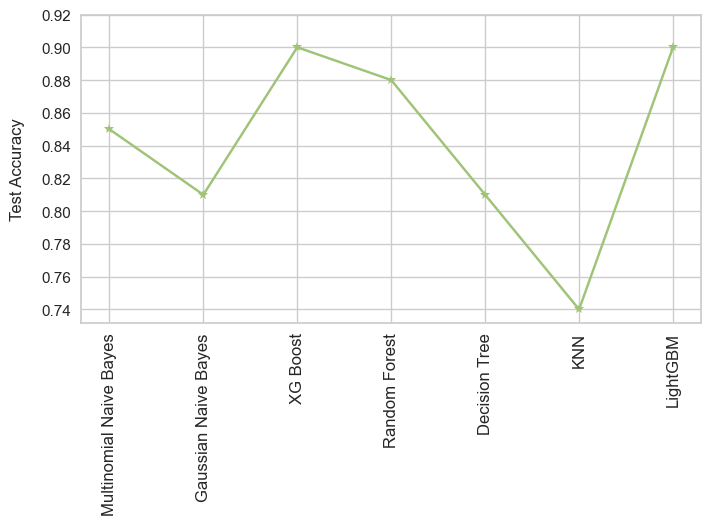

In [24]:
plt.figure(figsize = (8,4))

plt.plot(accuracies,'g-*')
plt.xticks(np.arange(0,7), labels = model_names, rotation = 'vertical',size = 12)
plt.ylabel('Test Accuracy',size = 12, labelpad = 12)
plt.yticks(np.arange(0.74,0.92,0.02),size = 11)

plt.show()

## Model Tuning (LightGBM)

In [27]:
estimator = LGBMClassifier()
lgbm_params = {
        'n_estimators': [100, 500, 1000],
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.1,0.01],
        "min_child_samples": [5,10,20]
}

rnd = RandomizedSearchCV(
    estimator=estimator, 
    param_distributions=lgbm_params,
    cv= 3, 
    verbose=3, 
    scoring='accuracy',
    return_train_score=True
)

rnd.fit(x_train,y_train)
rnd.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END learning_rate=0.1, max_depth=5, min_child_samples=10, n_estimators=100, subsample=0.8;, score=(train=0.891, test=0.884) total time=   0.3s
[CV 2/3] END learning_rate=0.1, max_depth=5, min_child_samples=10, n_estimators=100, subsample=0.8;, score=(train=0.894, test=0.875) total time=   0.3s
[CV 3/3] END learning_rate=0.1, max_depth=5, min_child_samples=10, n_estimators=100, subsample=0.8;, score=(train=0.898, test=0.868) total time=   0.3s
[CV 1/3] END learning_rate=0.01, max_depth=5, min_child_samples=5, n_estimators=100, subsample=0.6;, score=(train=0.832, test=0.837) total time=   0.3s
[CV 2/3] END learning_rate=0.01, max_depth=5, min_child_samples=5, n_estimators=100, subsample=0.6;, score=(train=0.832, test=0.829) total time=   0.3s
[CV 3/3] END learning_rate=0.01, max_depth=5, min_child_samples=5, n_estimators=100, subsample=0.6;, score=(train=0.838, test=0.824) total time=   0.4s
[CV 1/3] END learning_rate=

{'subsample': 1.0,
 'n_estimators': 1000,
 'min_child_samples': 20,
 'max_depth': 4,
 'learning_rate': 0.1}

In [28]:
lgbm_model = LGBMClassifier(
    subsample=1, 
    n_estimators=1000,
    min_child_samples=20,
    max_depth = 4,
    learning_rate = 0.1,
    random_state=0
)

lgbm_model.fit(x_train,y_train)

LGBMClassifier(max_depth=4, n_estimators=1000, random_state=0, subsample=1)

In [29]:
y_pred = lgbm_model.predict(x_train)

acc = round(accuracy_score(y_train,y_pred),2)
clf = classification_report(y_train,y_pred)

print("Training accuracy is: ",acc)
print("\n")
print("The classifiaction report:\n",clf)

Training accuracy is:  0.95


The classifiaction report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95      9828
           1       0.98      0.93      0.95      9755

    accuracy                           0.95     19583
   macro avg       0.95      0.95      0.95     19583
weighted avg       0.95      0.95      0.95     19583



In [31]:
y_pred = lgbm_model.predict(x_test)

acc = round(accuracy_score(y_test,y_pred),2)
clf = classification_report(y_test,y_pred)

print("Test accuracy is: ",acc)
print("\n")
print("The classifiaction report:\n",clf)

Test accuracy is:  0.9


The classifiaction report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91      4311
           1       0.92      0.88      0.90      4083

    accuracy                           0.90      8394
   macro avg       0.91      0.90      0.90      8394
weighted avg       0.91      0.90      0.90      8394



## Model Testing

In [33]:
while True:
    
    # testing the model whether it works for user input.
    dics = {1: "Mental health is not good!" , 0:"Mental healt is good!" }

    #user input
    text = input("\n\nEnter a text (-1 to exit) :\n\n-> ")
    if text == "-1":
        break
    elif text == "":
        print("\nError: Please enter a text!")
        continue


    # first we create a vector of this review
    vector1 = cnv.transform([text]).A

    # getting prediction
    prediction = lgbm_model.predict(vector1)

    # printing the results
    print(f"\n-> {dics[prediction[0]]}")
    



Enter a text (-1 to exit) :

-> i tried to kill myself twice.

-> Mental health is not good!


Enter a text (-1 to exit) :

-> i want to save the world.

-> Mental healt is good!


Enter a text (-1 to exit) :

-> 

Error: Please enter a text!


Enter a text (-1 to exit) :

-> -1
